In [1]:
import tensorflow as tf
import pandas as pd 
import re
import collections
import os
import numpy as np
import math
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from six.moves import xrange
from tempfile import gettempdir

In [2]:
movies = pd.read_csv("wiki_movie_plots.csv")

Step one: Convert plot to vectorized sequence of words.

Step two: Set up LSTM to generate predictions.

Step three: Interpret predictions.

Ideas:
- Predictions at every word (or sentence, or paragraph), see where they change

In [3]:
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [4]:
genres_to_consider = ["drama", "comedy", "horror", "action", "thriller", "romance", "western"]
movies = movies[movies['Genre'].isin(genres_to_consider)]

In [5]:
movies.groupby('Genre').count().sort_values("Title", ascending=False)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Wiki Page,Plot
Genre,,,,,,,
drama,5964,5964,5964,5964,5841,5964,5964
comedy,4379,4379,4379,4379,4347,4379,4379
horror,1167,1167,1167,1167,1124,1167,1167
action,1098,1098,1098,1098,1087,1098,1098
thriller,966,966,966,966,955,966,966
romance,923,923,923,923,918,923,923
western,865,865,865,865,864,865,865


In [6]:
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...
15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...
16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...


In [7]:
movies = movies.sample(frac=1) # Shuffles the data 

In [8]:
N_train = 600
N_test = 200

train = None
test = None

train = movies[movies['Genre'] == 'drama'][:N_train]
test = movies[movies['Genre'] == 'drama'][N_train:]

for genre in genres_to_consider[1:]:
    tr = movies[movies['Genre'] == genre][:N_train]
    te = movies[movies['Genre'] == genre][N_train:]
    train = pd.concat([train, tr])
    test = pd.concat([test, te])
    

In [9]:
train.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
248,1918,We Can't Have Everything,American,Cecil B. DeMille,"Kathlyn Williams, Elliott Dexter",drama,https://en.wikipedia.org/wiki/We_Can%27t_Have_...,"As described in a film magazine,[1] very much ..."
8562,1970,Jenny,American,George Bloomfield,"Marlo Thomas, Alan Alda",drama,https://en.wikipedia.org/wiki/Jenny_(1970_film),"Jenny, a young small-town woman, moves away to..."
22057,2003,Julie Walking Home,Canadian,Agnieszka Holland,"Miranda Otto, William Fichtner, Lothaire Blute...",drama,https://en.wikipedia.org/wiki/Julie_Walking_Home,Julie finds her husband Henry in bed with anot...
9468,1978,Days of Heaven,American,Terrence Malick,"Richard Gere, Brooke Adams",drama,https://en.wikipedia.org/wiki/Days_of_Heaven,"In 1916,[7] Bill (Gere), a Chicago manual labo..."
17784,2007,The Final Winter,Australian,Brian Andrews,"Matthew Nable, Matthew Johns",drama,https://en.wikipedia.org/wiki/The_Final_Winter,The film explores the way in which business to...


### Word Embeddings Using Word2Vec on Wikipedia Corpus

In [128]:
d = {
    "(" : " ( ",
    ")" : " ) ",
    "-" : " - ",
    "," : " , ",
    "\n" : "",
    "\r" : "",
    "\"" : " \" ",
    "'" : " ' ",
    "." : " . ",
    ";" : " ; ",
    ":" : " : ",
    "ENDOFARTICLE": ""
}

### Function to replace various characters in a single pass over text

In [129]:
def multiple_replace(d, text):
    
    regex = re.compile("(%s)" % "|".join(map(re.escape, d.keys())))
    
    return regex.sub(lambda x: d[x.string[x.start():x.end()]], text) 

## Parses (k) available wikipedia files 

In [131]:
filename = "wiki"
words = []
k = 60

files_in_directory = os.listdir(filename)
print("Files in directory: " + str(len(files_in_directory)))
print("Files being used: " + str(k))

for file in files_in_directory[:k]:
    f = open(filename + "/" + file, 'r', encoding = "ISO-8859-1")
    f = f.read()
    f = multiple_replace(d, f)
    f = re.sub("<doc.{20,150}>", "", f) # Gets rid of intro 
    f = re.sub("</doc>", "", f) # Gets rid of end
    f = re.sub("\[[0-9]+\]", "", f) # Gets rid of reference pointers 
    f = re.sub(" [A-Z]{1}[A-Z]+ ", " ", f)
    all_words = f.split(" ")
    for word in all_words:
        words.append(word.lower())


Files in directory: 164
Files being used: 60


## Function to generate vocabulary instances 

In [132]:
def build_batch(words, n_words):
    word_count = [["UNK", -1]]
    word_count.extend(collections.Counter(words).most_common(n_words - 1))
    
    d = {}
    for w, _ in word_count:
        d[w] = len(d)
        
    data = []
    num_unks = 0
    for w in words:
        index = d.get(w, 0)
        if index == 0:
            num_unks += 1
        data.append(index)
            
    word_count[0][1] = num_unks
    
    reversed_dictionary = dict(zip(d.values(), d.keys()))
    
    return data, word_count, d, reversed_dictionary

In [133]:
n_words = 50000 # Subject to change 
data, word_count, vocab_dictionary, reversed_dictionary = build_batch(words, n_words)

In [134]:
word_index = len(words)

## Generates a batch of wikipedia data to be used for the Word2Vec model

In [135]:
data_index = 0
def generate_batch(batch_size, data, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
            
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

## Parameters for the Word2Vec Model

In [136]:
batch_size = 256
embedding_size = 128
skip_window = 1
num_skips = 2
num_sampled = 64

valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [137]:
graph = tf.Graph()

with graph.as_default():
    
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    with tf.name_scope('embeddings'):
        embeddings = tf.Variable(
            tf.random_uniform([n_words, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    with tf.name_scope("weights"):
        
        nce_weights = tf.Variable(tf.truncated_normal([n_words, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        
    with tf.name_scope('biases'):
        
        nce_biases = tf.Variable(tf.zeros([n_words]))
        
    with tf.name_scope('loss'):
      loss = tf.reduce_mean(
          tf.nn.nce_loss(
              weights=nce_weights,
              biases=nce_biases,
              labels=train_labels,
              inputs=embed,
              num_sampled=num_sampled,
              num_classes=n_words))
    
    tf.summary.scalar('loss', loss)
    
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                              valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)
    
    merged = tf.summary.merge_all()
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    

# Run model to obtain embeddings for each word 

In [ ]:
n_steps = 250001 # Can increase 
log_dir = "182/LSTMsAndInterpretability"

with tf.Session(graph=graph) as session:
    
    writer = tf.summary.FileWriter(log_dir, session.graph)
    
    init.run()
    print('Initialized')
    
    average_loss = 0
    for step in range(n_steps):
        batch_inputs, batch_labels = generate_batch(batch_size,
                                                  data,
                                                  num_skips,
                                                  skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        run_metadata = tf.RunMetadata()
    
        _, summary, loss_val = session.run([optimizer, merged, loss],
                                         feed_dict=feed_dict,
                                         run_metadata=run_metadata)
    
        average_loss += loss_val
    
        if step % 5000 == 0:
            if step > 0:
                average_loss /= 5000
            # The average loss is an estimate of the loss over the last 5000
            # batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
            
    final_embeddings = normalized_embeddings.eval()
        
    with open(log_dir + '/metadata.tsv', 'w') as f:
        for i in range(n_words):
            f.write(reversed_dictionary[i] + '\n')
        
    saver.save(session, os.path.join(log_dir, 'model.ckpt'))

Initialized
Average loss at step  0 :  264.95458984375
Average loss at step  5000 :  73.03221829595566
Average loss at step  10000 :  21.62651866414547
Average loss at step  15000 :  11.575616943502427
Average loss at step  20000 :  7.922073570251465
Average loss at step  25000 :  6.834495625114441
Average loss at step  30000 :  5.77323733959198
Average loss at step  35000 :  5.351610441923142
Average loss at step  40000 :  5.084962129926682
Average loss at step  45000 :  4.925912883710861
Average loss at step  50000 :  4.779864559912681
Average loss at step  55000 :  4.67302426738739
Average loss at step  60000 :  6.9921565089941025
Average loss at step  65000 :  5.211028605270386
Average loss at step  70000 :  4.681835261583328
Average loss at step  75000 :  4.54636197309494


## Computes cosine similarity between two vectors

In [72]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

## Function finds the closest word embeddings to a given word and returns their indices

In [ ]:
def find_closest(embeddings, word, index_to_word, word_to_index, n_words, count):
    assert word in word_to_index, 'Unknown word'
    
    print("Word occurs: " + str(count[word_to_index[word]][1]) + " times.\n")
    
    word_embedding = embeddings[word_to_index.get(word)]
    
    distances = np.sum((embeddings - word_embedding) ** 2, axis=1)
    
    indices = np.argsort(distances)[:n_words]
    for i in indices:
        print(index_to_word.get(i, "UNK"))
    
    return indices

In [ ]:
find_closest(final_embeddings, "jesus", reversed_dictionary, vocab_dictionary, 20, word_count)

## Plots TSNE for most common words

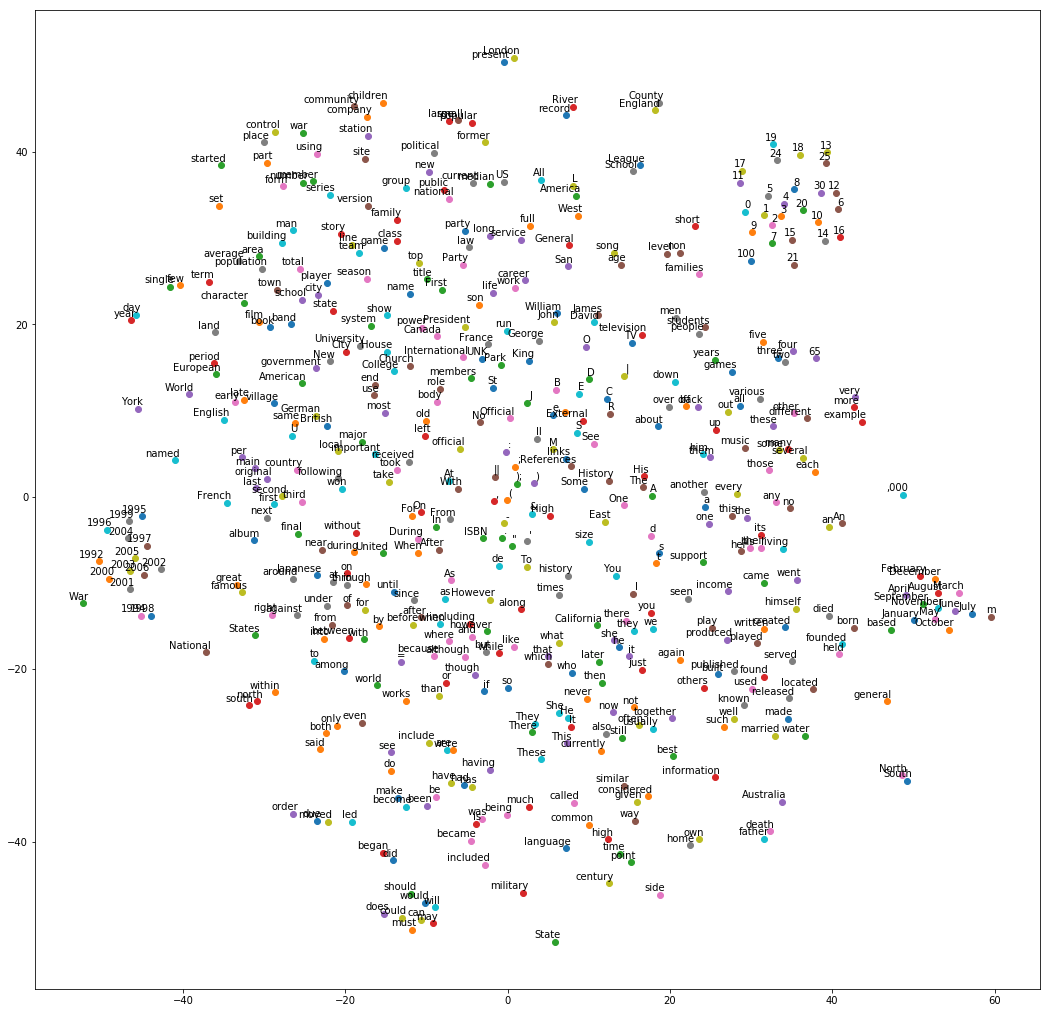

In [70]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy = (x, y), xytext = (5, 2), textcoords = 'offset points', ha='right', va='bottom')
        
try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(
        perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reversed_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(),
                                                        'tsne.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

In [23]:
# Set up LSTM

In [24]:
train.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
248,1918,We Can't Have Everything,American,Cecil B. DeMille,"Kathlyn Williams, Elliott Dexter",drama,https://en.wikipedia.org/wiki/We_Can%27t_Have_...,"As described in a film magazine,[1] very much ..."
8562,1970,Jenny,American,George Bloomfield,"Marlo Thomas, Alan Alda",drama,https://en.wikipedia.org/wiki/Jenny_(1970_film),"Jenny, a young small-town woman, moves away to..."
22057,2003,Julie Walking Home,Canadian,Agnieszka Holland,"Miranda Otto, William Fichtner, Lothaire Blute...",drama,https://en.wikipedia.org/wiki/Julie_Walking_Home,Julie finds her husband Henry in bed with anot...
9468,1978,Days of Heaven,American,Terrence Malick,"Richard Gere, Brooke Adams",drama,https://en.wikipedia.org/wiki/Days_of_Heaven,"In 1916,[7] Bill (Gere), a Chicago manual labo..."
17784,2007,The Final Winter,Australian,Brian Andrews,"Matthew Nable, Matthew Johns",drama,https://en.wikipedia.org/wiki/The_Final_Winter,The film explores the way in which business to...


## Function to encode the genre to be used for LSTM classification

In [25]:
def encodeLabel(df, col, label_col="Label"):
    df[col] = df[col].astype('category')
    df[label_col] = df[col].cat.codes
    return df

In [26]:
train = encodeLabel(train, "Genre")

In [27]:
train_plot_words = train['Plot'].tolist()
train_labels = train['Label'].tolist()
train_labels = np.array(train_labels)

## Maps each word in a given plot to its embedding 

In [29]:
def get_embeddings(plot_list, final_embeddings):
    plot_embeddings = []
    
    for plot in plot_list:
    
        embeddings = []
    
        p = multiple_replace(d, plot)
    
        all_words = p.split(" ")
    
        for word in all_words:
        
            index = vocab_dictionary.get(word, 0)
        
            embedding = final_embeddings[index]
            embeddings.append(embedding)
            
        plot_embeddings.append(embeddings)
        
    return plot_embeddings

In [30]:
train_plot_embeddings = get_embeddings(train_plot_words, final_embeddings)
train_plot_embeddings = np.array(train_plot_embeddings)

## Generates a batch of movies to be used for LSTM model

In [32]:
def generate_batch_movies(batch_size, plots, labels):
    # Assert ndarrays 
    
    total = len(plots)
    
    indices = np.random.choice(total, batch_size, replace=False)
    
    batch_plots = np.take(plots, indices)
    batch_labels = np.take(labels, indices)
    
    return batch_plots, batch_labels

In [33]:
batch_inputs, batch_labels = generate_batch_movies(20, train_plot_embeddings, train_labels)

In [75]:
class LSTMModel():
    
    def __init__(self, rnn_size, output_size, learning_rate=1e-4):

        self.inputs = tf.placeholder(tf.float32, shape=[None, None, embedding_size])
        self.labels = tf.placeholder(tf.int32, shape=[None, 1])
    
        lm_cell = tf.nn.rnn_cell.LSTMCell(rnn_size)
    
        outputs, states = tf.nn.dynamic_rnn(lm_cell, self.inputs, dtype=tf.float32)
    
        self.output_logits = tf.layers.dense(outputs, output_size)
    
        self.loss = tf.losses.sparse_softmax_cross_entropy(self.labels, self.output_logits)
        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        
        self.global_step = tf.train.get_or_create_global_step()
        self.train_op = optimizer.minimize(self.loss)
        self.saver = tf.train.Saver()


In [76]:
tf.reset_default_graph() # This is so that when you debug, you reset the graph each time you run this, in essence, cleaning the board
model = LSTMModel(256, 7, 1e-3)

Instructions for updating:
Use tf.cast instead.


In [ ]:
# example
batch_size = 20
for i in range(10):
    
    batch_inputs, batch_labels = generate_batch_movies(batch_size, train_plot_embeddings, train_labels)
    
    feed_dict = {model.inputs: batch_inputs, model.labels: batch_labels}
    
    sess.run([self.train_op], feed_dict={})